# GWANW 2021 Meeting
## LIGO Data Tutorial
LIGO data can be accessed with the GWpy Python package. This workbook will describe how to download publicly-available gravitational wave data and process it with GWpy. Installation instructions for GWpy may be found [here](https://gwpy.github.io/docs/stable/install/index.html). This tutorial uses version 2.0.3 of GWpy for python 3.6+.

In [185]:
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import matplotlib.pyplot as plt
from scipy.signal import get_window
%matplotlib inline

tconvert is a useful utility for converting between GPS times and human-readable times. The LIGO GPS time standard counts the number of seconds since 00:00:00 UTC on January 6, 1980.

In [186]:
print(tconvert(0))  # What UTC time does the GPS time of 0 correspond to?

1980-01-06 00:00:00


In [187]:
print(tconvert('January 6, 1980 00:00:00'))  # What GPS time does 1/6/1980 00:00:00 correspond to?

0


In [188]:
print(tconvert('now'))
print(tconvert(tconvert('now')))  # What time is it now?

1308939401
2021-06-28 18:16:23


Let's use GWpy's data-fetching methods to grab data from a LIGO event. According to the [O3a catalog](https://arxiv.org/abs/2010.14527), there was a gravitational wave detected by LIGO Hanford ("H1") and LIGO Livingston ("L1") on May 21, 2019 at 7:43:59 UTC. Up to 4096 seconds of strain data are available from around the event. 

In [189]:
t0 = tconvert('May 21, 2019 07:43:59')
t_start = t0 - 16
t_end = t0 + 16
h1_data = TimeSeries.fetch_open_data(ifo = 'H1', start = t_start, end = t_end, sample_rate = 16384, verbose = True)

Fetched 1 URLs from www.gw-openscience.org for [1242459841 .. 1242459873))
Reading data... [Done]


We can plot the resulting timeseries.

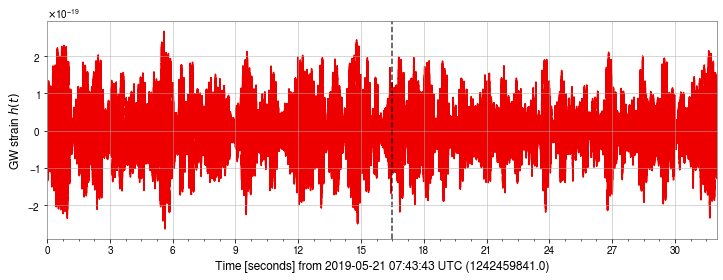

In [190]:
plot = h1_data.plot(c = 'gwpy:ligo-hanford')
plt.ylabel(r'GW strain $h(t)$')
plt.axvline(1242459857.46, ls = '--', alpha = .75, c= 'k')
plot.show()

Each gwpy.timeseries.TimeSeries object has several attributes in addition to the array of $h(t)$ measurements.

In [191]:
print(h1_data.value)  # The list of h(t) at each time

[-4.43491012e-20 -4.21965246e-20 -3.50013037e-20 ...
 -1.13478515e-19 -1.15156042e-19 -9.24125947e-20]


In [192]:
print(h1_data.unit)         # Strain is unitless (meters/meters), so this is just a blank line
print(h1_data.t0)           # GPS start time of the data
print(h1_data.dt)           # Time increments between data points
print(h1_data.sample_rate)  # Sample rate of channel
print(h1_data.times)        # List of GPS times at which the  data is sampled
print(h1_data.name)         # Descriptive name for the dataset


1242459841.0 s
6.103515625e-05 s
16384.0 Hz
[1.24245984e+09 1.24245984e+09 1.24245984e+09 ... 1.24245987e+09
 1.24245987e+09 1.24245987e+09] s
Strain


In [193]:
l1_data = TimeSeries.fetch_open_data(ifo = 'L1', start = t_start, end = t_end, sample_rate = 16384, verbose = False)

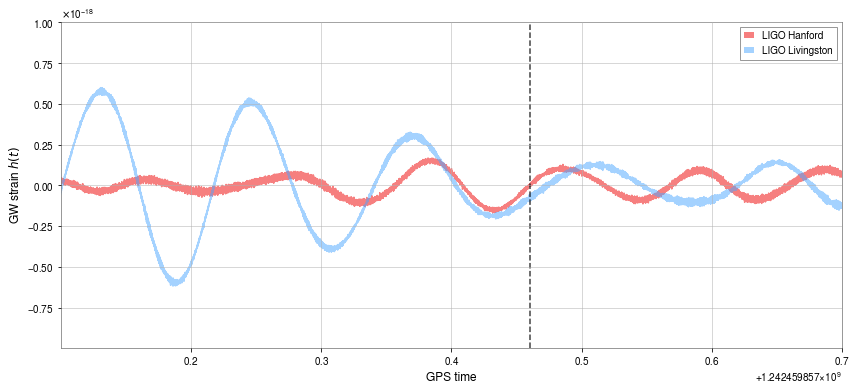

In [194]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford', alpha = .5)
ax.plot(l1_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston', alpha = .5)
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlabel('GPS time')
ax.set_xlim(1242459857.46 - .36, 1242459857.46 + .24)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1242459857.46, ls = '--', alpha = .75, c= 'k')
plot.show()

There doesn't appear to be anything exceptional happening in the detectors at the quoted merger time, even though this is one of the highest SNR events in the GWTC-2 catalog. What gives?

It is easy to compute the frequency-domain representation of the $h(t)$ data for either detector.

In [195]:
h1_data_freq_domain = h1_data.fft()

This produces a FrequencySeries object which has similar properties and attributes to a TimeSeries.

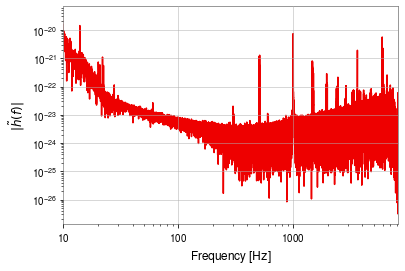

In [196]:
plot = h1_data_freq_domain.abs().plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log')
plt.ylabel(r'$|\tilde{h}(f)|$')
plt.xlim(10, 8192)
plot.show()

In [162]:
window_fct = get_window(window = 'hann', Nx = h1_data.size)

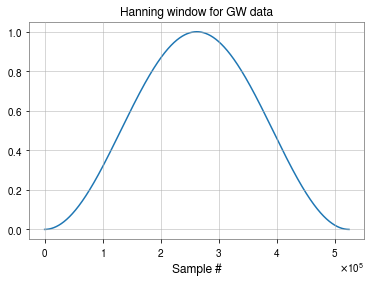

In [163]:
plt.plot(window_fct)
plt.xlabel('Sample #')
plt.title('Hanning window for GW data')
plt.show()

In [164]:
windowed_h1_data = window_fct * h1_data

The result of the windowing is to decrease the values of $h(t)$ recorded at the start and end of the dataset.

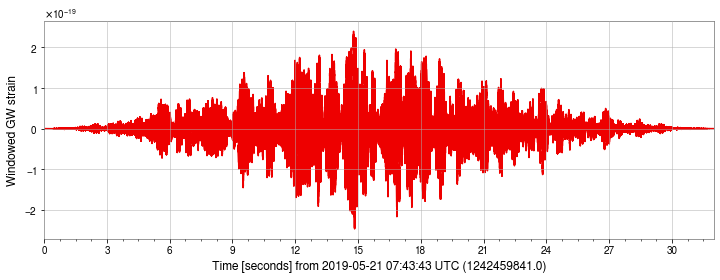

In [165]:
plot = windowed_h1_data.plot(c = 'gwpy:ligo-hanford')
plt.ylabel(r'Windowed GW strain')
plot.show()

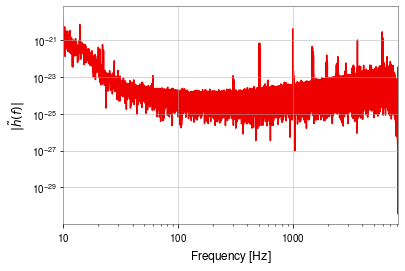

In [166]:
h1_windowed_data_freq_domain = windowed_h1_data.fft()
plot = h1_windowed_data_freq_domain.abs().plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log')
plt.ylabel(r'$|\tilde{h}(f)|$')
plt.xlim(10, 8192)
plot.show()

By combining several FFTs, we are able to get a snapshot of the detector's sensitivity at the time of the event that isn't subject to short variations in detector noise. The windowing step is done automatically by the aasd() method.

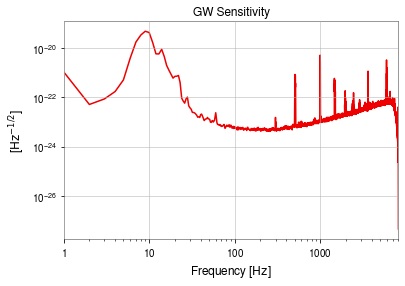

In [167]:
h1_asd = h1_data.asd(fftlength = 1, overlap = .25, window = 'hann', method = 'welch')
plot = h1_asd.plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log')
plt.title('GW Sensitivity')
plt.show()

We can also whiten the data. GWpy uses inverse spectrum truncation to boost the amplitude of the signal at low-amplitude frequencies and reduce the signal amplitude at high amplitude frequencies. ASDs like the ones we have made are used to whiten the data.

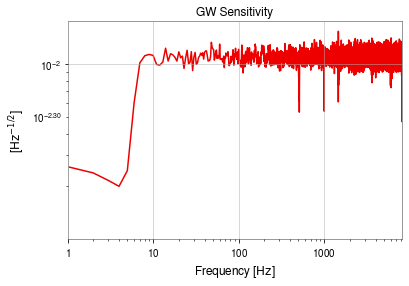

In [168]:
h1_data_whitened = h1_data.whiten()
h1_whitened_asd = h1_data_whitened.asd(fftlength = 1, overlap = .25, window = 'hann', method = 'welch')
plot = h1_whitened_asd.plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log')
plt.title('GW Sensitivity')
plt.show()

The signal is approixmately "white" or "flat" above 10 Hz. We're really not interested in the low frequency content anyway, so this should be good. We will highpass the signal above 20 Hz to be sure. Now we can repeat the process for LIGO Livingston.

In [169]:
h1_final_data = h1_data.highpass(20).whiten()

In [170]:
l1_final_data = l1_data.highpass(20).whiten()

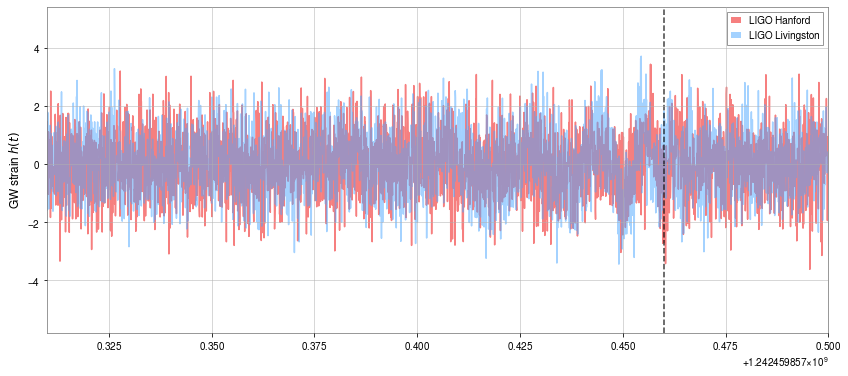

In [171]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford', alpha = .5)
ax.plot(l1_final_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston', alpha = .5)
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1242459857.46 - .15, 1242459857.46 + .04)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1242459857.46, ls = '--', alpha = .75, c= 'k')
plot.show()

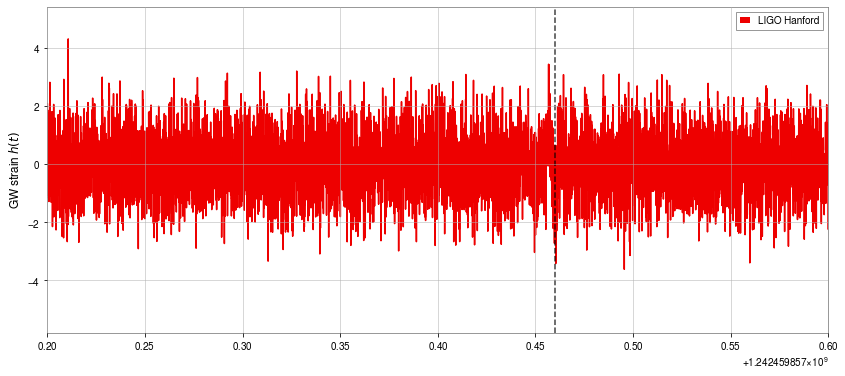

In [172]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford')
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1242459857.46 - .26, 1242459857.46 + .14)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1242459857.46, ls = '--', alpha = .75, c= 'k')
plot.show()

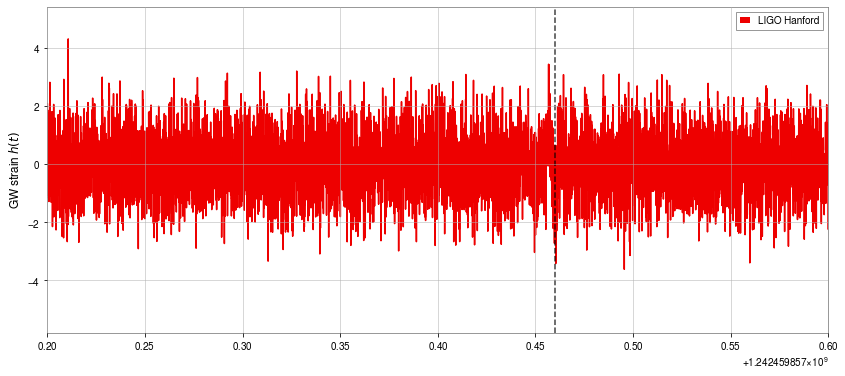

In [173]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford')
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1242459857.46 - .26, 1242459857.46 + .14)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1242459857.46, ls = '--', alpha = .75, c= 'k')
plot.show()

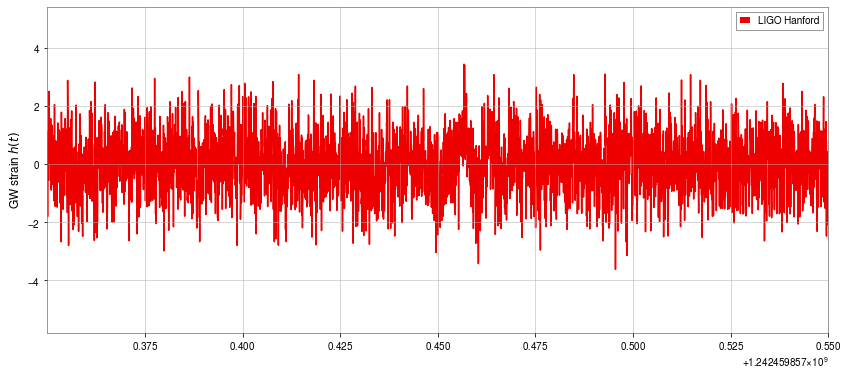

In [174]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford')
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1242459857.46 - .11, 1242459857.46 + .09)  # Event time from the listing on GraceDB
ax.legend()
plot.show()

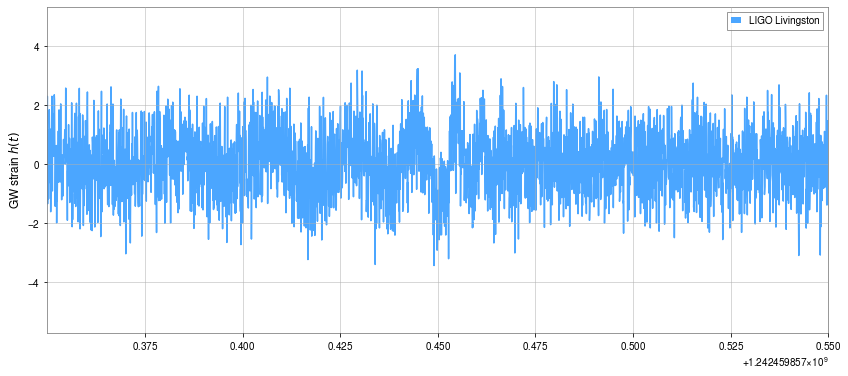

In [175]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(l1_final_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston')
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1242459857.46 - .11, 1242459857.46 + .09)  # Event time from the listing on GraceDB
ax.legend()
plot.show()

Zooming in, the GW can be picked out of both detector's data by eye.

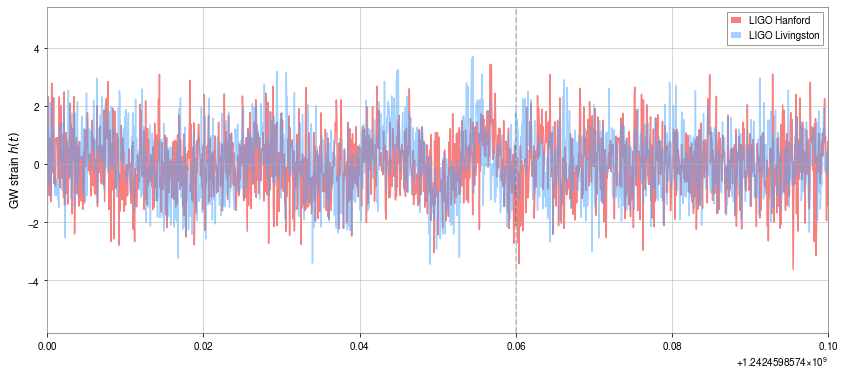

In [176]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford', alpha = .5)
ax.plot(l1_final_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston', alpha = .5)
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1242459857.46 - .06, 1242459857.46 + .04)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1242459857.46, ls = '--', alpha = .25, c= 'k')
plot.show()

In [177]:
specgram = h1_final_data.crop(1242459847.46, 1242459867.46).spectrogram2(fftlength=1/16., overlap=1/32.) ** (1/2.)
specgram = specgram.crop_frequencies(20)  # drop everything below highpass

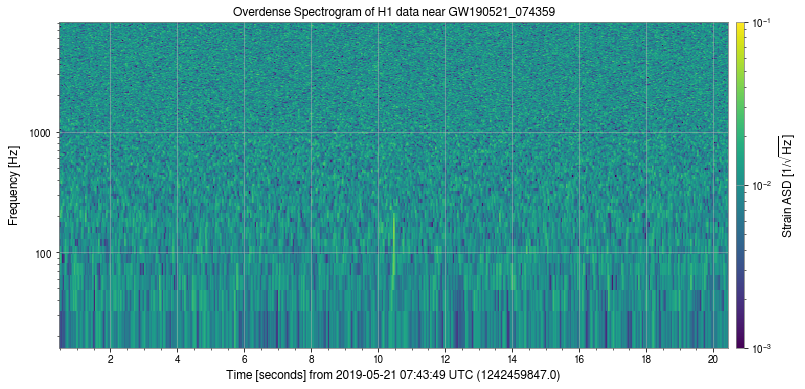

In [178]:
plot = specgram.plot(norm='log', cmap='viridis', yscale='log', vmin = 1e-3, vmax = .1)
ax = plot.gca()
ax.set_title('Overdense Spectrogram of H1 data near GW190521_074359')
ax.set_xlim(1242459847.46, 1242459867.46)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()

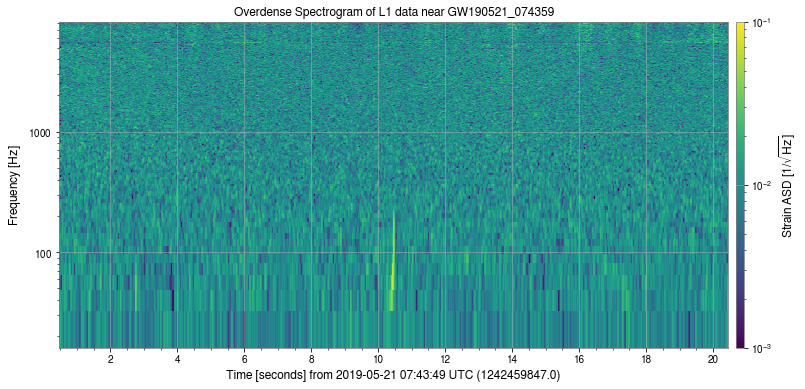

In [179]:
specgram = l1_final_data.crop(1242459847.46, 1242459867.46).spectrogram2(fftlength=1/16., overlap=1/32.) ** (1/2.)
specgram = specgram.crop_frequencies(20)  # drop everything below highpass
plot = specgram.plot(norm='log', cmap='viridis', yscale='log', vmin = 1e-3, vmax = .1)
ax = plot.gca()
ax.set_title('Overdense Spectrogram of L1 data near GW190521_074359')
ax.set_xlim(1242459847.46, 1242459867.46)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()

We can compute the PSD just as we found the ASD. Note the different units.

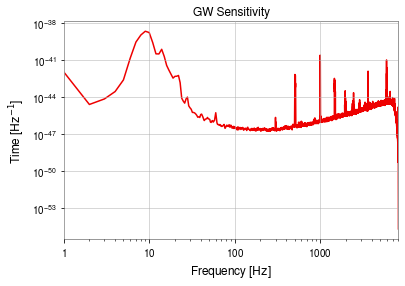

In [181]:
h1_psd = h1_data.psd(fftlength = 1, overlap = .25, window = 'hann', method = 'welch')
plot = h1_psd.plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log')
plt.title('GW Sensitivity')
plt.show()

And we can also find the Q-transform.

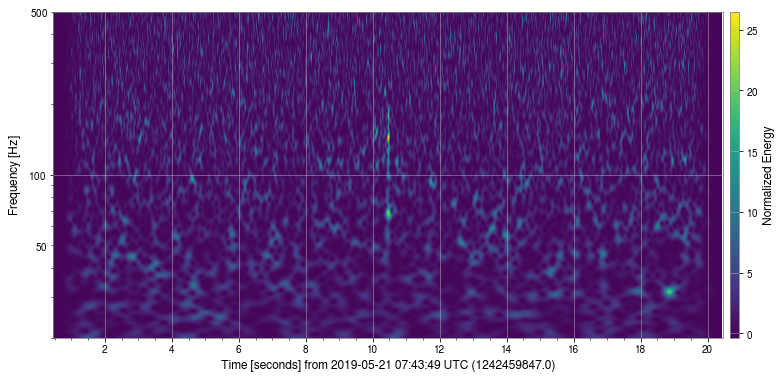

In [183]:
qtrans = h1_data.crop(1242459847.46, 1242459867.46).q_transform(frange = (20, 500), qrange = (30, 80), whiten = True, fres = .01, tres = .01)
plot = qtrans.plot()
plot.colorbar(label = 'Normalized Energy')
ax = plot.gca()
ax.set_yscale('log')
plot.show()

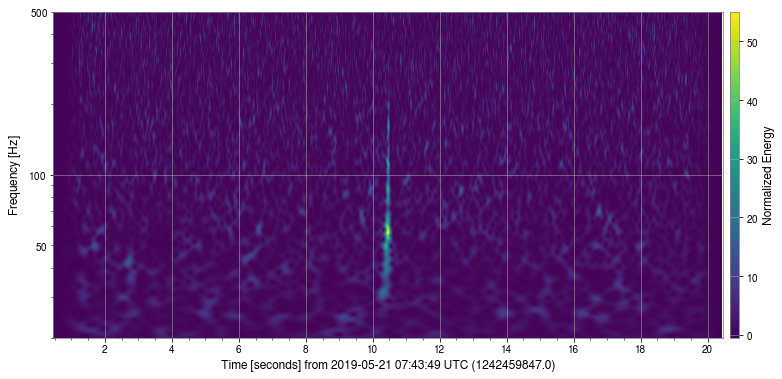

In [184]:
qtrans = l1_data.crop(1242459847.46, 1242459867.46).q_transform(frange = (20, 500), qrange = (30, 80), whiten = True, fres = .01, tres = .01)
plot = qtrans.plot()
plot.colorbar(label = 'Normalized Energy')
ax = plot.gca()
ax.set_yscale('log')
plot.show()